In [241]:
import tensorflow as tf
import numpy as np

In [262]:
X_train = tf.linspace(0., 10., 100)
X_train = tf.reshape(X_train, [-1, 1])
X_train[:10]


<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.       ],
       [0.1010101],
       [0.2020202],
       [0.3030303],
       [0.4040404],
       [0.5050505],
       [0.6060606],
       [0.7070707],
       [0.8080808],
       [0.9090909]], dtype=float32)>

In [263]:
def true_f(X:tf.Tensor):
    y =  X**2 + 2*X + 1
    return y

def noise_f(y:tf.Tensor):
    noise = tf.random.normal(shape=y.shape, mean=0, stddev=2)
    return y+noise


In [264]:
y_train = noise_f(true_f(X_train))
y_train[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 0.62967455],
       [-2.0079908 ],
       [ 0.09748876],
       [ 0.4503001 ],
       [ 2.2044735 ],
       [ 6.3293715 ],
       [ 0.5725267 ],
       [ 4.95146   ],
       [ 4.1573725 ],
       [ 2.9585025 ]], dtype=float32)>

In [265]:
import matplotlib.pyplot as plt


In [266]:
class DenseLayerG(tf.keras.layers.Layer):
    def __init__(self, units=None, name=None, activation=None):
        super(DenseLayerG,self).__init__(name=name)
        self.units = units 
        self._activation = activation

    def build(self, input_shape):
        
        self.w = self.add_weight(f"{self.name}_w", shape=[input_shape[-1],self.units], 
                                 initializer=tf.random_normal_initializer(0,1))
        self.b = self.add_weight(f"{self.name}_b", shape=[self.units], 
                                 initializer=tf.zeros_initializer())

    def call(self, inputs):      
        y = tf.matmul(inputs, self.w) + self.b
        # print(f"Layer {self.name} input shape: {inputs.shape}, output shape: {y.shape}")
        if self._activation:
            y = self._activation(y)
        return y
    
class SeqModelG(tf.keras.Model):
    def __init__(self):
        super(SeqModelG, self).__init__()
        self.layer1 = DenseLayerG(9,name="layer1", activation=tf.nn.relu)
        self.layer1g = DenseLayerG(14,name="layer1g", activation=tf.nn.relu)
        
        self.layer2 = DenseLayerG(1,name="layer2")

    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.layer1g(x)
        x = self.layer2(x)
        return x

In [267]:

model = SeqModelG()


In [268]:
model(X_train[:10])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 0.        ],
       [-0.66263324],
       [-1.3252665 ],
       [-1.9878999 ],
       [-2.650533  ],
       [-3.3131664 ],
       [-3.9757998 ],
       [-4.638433  ],
       [-5.301066  ],
       [-5.9637    ]], dtype=float32)>

In [282]:
def train(model, X_train, y_train, epochs=100, lr=0.1):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    indices = np.arange(len(X_train))
    np.random.default_rng(69).shuffle(indices)
        
    for epoch in range(epochs):
        for batch_start in range(0, len(X_train), 11):
            batch_idx = indices[batch_start:batch_start + 11]
            with tf.GradientTape() as tape:
                y_pred = model(tf.gather(X_train, batch_idx))
                loss = tf.reduce_mean(tf.square(y_pred - tf.gather(y_train, batch_idx)))
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            if batch_start%11==0:
                print(f"Epoch {epoch} Batch {batch_start} Loss {loss.numpy()}")
        # if epoch%10==0:
        #     print(f"Epoch {epoch} Loss {loss.numpy()}")
    return model

In [287]:
m = train(model, X_train, y_train, epochs=100, lr=0.01)
y_pred = m(X_train)

Epoch 0 Batch 0 Loss 1.9164390563964844
Epoch 0 Batch 11 Loss 2.9077532291412354
Epoch 0 Batch 22 Loss 2.3645613193511963
Epoch 0 Batch 33 Loss 1.7091622352600098
Epoch 0 Batch 44 Loss 2.1834325790405273
Epoch 0 Batch 55 Loss 4.039433479309082
Epoch 0 Batch 66 Loss 4.738498210906982
Epoch 0 Batch 77 Loss 8.315410614013672
Epoch 0 Batch 88 Loss 5.125650882720947
Epoch 0 Batch 99 Loss 2.0650794506073
Epoch 1 Batch 0 Loss 1.7669849395751953
Epoch 1 Batch 11 Loss 2.651010751724243
Epoch 1 Batch 22 Loss 2.3275339603424072
Epoch 1 Batch 33 Loss 1.7517567873001099
Epoch 1 Batch 44 Loss 2.1468069553375244
Epoch 1 Batch 55 Loss 4.231527328491211
Epoch 1 Batch 66 Loss 6.6940765380859375
Epoch 1 Batch 77 Loss 9.631355285644531
Epoch 1 Batch 88 Loss 3.3011245727539062
Epoch 1 Batch 99 Loss 0.003396223997697234
Epoch 2 Batch 0 Loss 1.816341519355774
Epoch 2 Batch 11 Loss 2.6434929370880127
Epoch 2 Batch 22 Loss 3.099137783050537
Epoch 2 Batch 33 Loss 5.037415027618408
Epoch 2 Batch 44 Loss 3.978111

In [288]:
m.trainable_weights

[<tf.Variable 'seq_model_g_36/layer1/layer1_w:0' shape=(1, 9) dtype=float32, numpy=
 array([[-0.6119324 ,  1.0769844 ,  0.40710476,  0.7679431 , -0.2879501 ,
          0.08324865,  0.6024664 ,  2.42715   , -0.59838676]],
       dtype=float32)>,
 <tf.Variable 'seq_model_g_36/layer1/layer1_b:0' shape=(9,) dtype=float32, numpy=
 array([ 0.        , -7.1367054 , -0.03537824, -5.5611343 ,  0.        ,
        -1.6249839 , -3.3739438 , -3.5374415 ,  0.        ], dtype=float32)>,
 <tf.Variable 'seq_model_g_36/layer1g/layer1g_w:0' shape=(9, 14) dtype=float32, numpy=
 array([[-1.0563236e+00,  1.1250269e+00, -1.1164384e+00, -3.0288288e-01,
          3.8980711e-01,  3.1932980e-01, -2.6118236e-02, -5.0813049e-01,
          5.6568950e-01, -7.7897745e-01,  1.5646343e+00, -1.2766193e+00,
         -1.2874908e-02,  9.8211974e-01],
        [ 8.8466966e-01,  2.6928049e-01, -1.1342055e+00, -9.6832430e-01,
          4.1742067e+00, -4.1397735e-01, -1.2446526e+00, -1.3619994e+00,
          1.3352472e+00, -4.

Text(0.5, 1.0, 'Line Plot of X_train and y_pred')

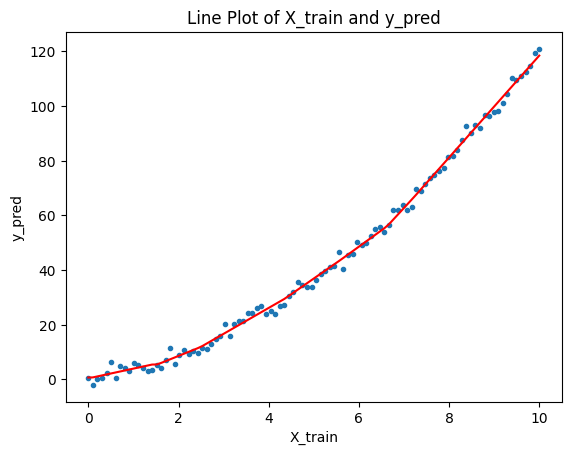

In [289]:
plt.plot(X_train, y_train, marker='.', linestyle='none', label='data')
plt.plot(X_train, y_pred, color='red', label='pred')
# plt.plot(X_train, true_f(X_train), color='green', label='truth')
plt.xlabel('X_train')
plt.ylabel('y_pred')
plt.title('Line Plot of X_train and y_pred')
